The main idea of avoiding of redundant constants is in using Strongly Typed Genetic Programming as Loosely Typed. 

There are two types of terminals. The first one is variable (hybgp.types.Var). Arguments of PrimitiveTree object are variables, for example. The second type is constant (hybgp.types.Const). They are produced automaticly in appropriate places by the hybgp.egp.generate function. For example, we obtain only $c_1 x + c_2 y + c_3$ instead of $x + y$ when we use hybgp.egp.generate function.

There are two more type of primitives. They aren't used like terminals but used like nodes. The first one is weighted type (hybgp.types.Weighted). Intuitively, it is a dimensionless value like $a x$, where $x$ has the variable type. The second is weighted-shifted type (hybgp.types.WSed). Intuitively, it is a weighted value which was shifted by adding a constant: $a x + b$.

Types of arguments of PrimitiveTree are not fixed (Loosely Typed GP). It could be np.array, int, etc. On the other hand types are constrained by Var, Const, Weighted, WSed relations (Strongly Typed GP).

We should use hybgp.operators.add and hybgp.operators.mul operators since these names are readable for SymPy and used in the generate function. (# add) and (# mul) blocks repeat in almost every cases.

In [1]:
from deap import gp
import numpy as np
from hybgp.types import Const, Var, WSed, Weighted
from hybgp.operators import mul, add


pset = gp.PrimitiveSetTyped("MAIN", [Var], WSed, prefix='x')

# add
pset.addPrimitive(add, [Weighted, Const], WSed)
pset.addPrimitive(add, [Weighted, Weighted], Weighted)

# mul
pset.addPrimitive(mul, [Const, Var], Weighted)
pset.addPrimitive(mul, [Var, Var], Var)

# exp
pset.addPrimitive(np.exp, [Weighted], Var)

# sin
pset.addPrimitive(np.sin, [Weighted], Var)

/home/shmax3/Desktop/deap/lib/python3.6/site-packages/deap/tools/_hypervolume/pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


Standart initialization of DEAP toolbox instead of moments when we use hybgp.egp.

In [2]:
from deap import creator, base, tools
from hybgp import egp

    
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", egp.PrimitiveTree, fitness=creator.FitnessMin,
               pset=pset)
toolbox = base.Toolbox()
toolbox.register("expr", egp.generate, pset=pset, min_=1, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", egp.compile, pset=pset)

Let the prior best solution of the task as PrimitiveTree be

In [3]:
from IPython.display import Math

prior_best = egp.PrimitiveTree([gp.Primitive('Add', [Weighted, Const], WSed),
                                gp.Primitive('Mul', [Const, Var], Weighted),
                                gp.Primitive('sin', [Weighted], Var),
                                gp.Primitive('Mul', [Const, Var], Weighted),
                                Const(0.5),
                                pset.terminals[Var][0],
                                Const(2),
                                Const(1)])

Math(prior_best.latex(False))

<IPython.core.display.Math object>

In [4]:
import numpy as np

X = np.linspace(0, 10, 100)
Y = toolbox.compile(prior_best)(X) + np.random.normal(0, 0.1, 100)

target = Y
args = (X,)

In [5]:
import operator

import inspect
import functools

from scipy.optimize import minimize
from hybgp.evaluators import linear_evaluator 
from hybgp.metrics import mse, parameters_num
from hybgp.adapters import scipy_minimize_adapter


optimizer = functools.partial(scipy_minimize_adapter(minimize),
                              method='SLSQP',
                              options={'maxiter': 100})

def metric(params, func, args, target):
    return mse(params, func, args, target)

evaluate = linear_evaluator(metric, (args, target), optimizer, toolbox)

toolbox.register("evaluate", evaluate)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", egp.generate, pset=pset, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))

/home/shmax3/Desktop/deap/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [6]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

In [7]:
from deap import algorithms

pop = toolbox.population(n=299)

hof = tools.HallOfFame(5)
try:
    pop, log = algorithms.eaSimple(pop, toolbox, 0.8, 0.1, 20, stats=stats,
                                   halloffame=hof, verbose=True)
except KeyboardInterrupt:
    pass

gen	nevals	avg     	min     	max    
0  	299   	0.779806	0.382933	2.03101
1  	253   	0.722181	0.382933	2.03101
2  	251   	0.682013	0.382933	0.72425


<string>:1: RuntimeWarning: overflow encountered in exp
/home/shmax3/Desktop/deap/hybgp/hybgp/metrics.py:16: RuntimeWarning: overflow encountered in square
  return (np.square(val - target) / sigma2).mean()


3  	245   	0.616825	0.35325 	2.03101


/home/shmax3/Desktop/deap/hybgp/hybgp/decorators.py:8: RuntimeWarning: overflow encountered in multiply
  return func(*args, **kwargs)


4  	238   	0.537384	0.35325 	3.65574
5  	262   	0.470152	0.35325 	3.65574
6  	250   	0.429497	0.35325 	3.65446
7  	255   	0.474016	0.35325 	3.65574
8  	248   	0.483595	0.0607305	3.65446


/home/shmax3/Desktop/deap/lib/python3.6/site-packages/scipy/optimize/slsqp.py:63: RuntimeWarning: invalid value encountered in subtract
  jac[i] = (func(*((x0+dx,)+args)) - f0)/epsilon


9  	246   	0.464881	0.0607305	3.6701 
10 	242   	0.415086	0.0607305	3.65446
11 	241   	0.486524	0.0607305	3.65446
12 	248   	0.419389	0.0607305	3.65446
13 	252   	0.460519	0.0607305	3.65446
14 	251   	0.466212	0.0607305	3.65446
15 	241   	0.438371	0.0607305	3.65446
16 	240   	0.481904	0.0607305	3.65446
17 	244   	0.447325	0.0607305	3.65446
18 	236   	0.492772	0.00947638	3.65446
19 	252   	0.434524	0.00947634	3.65446
20 	253   	0.474529	0.00947632	3.65574


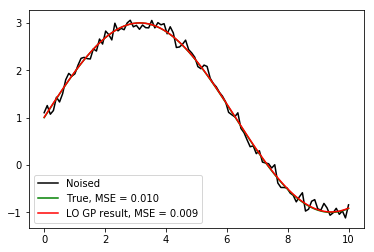

<IPython.core.display.Math object>

In [9]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
%matplotlib inline


func_true = toolbox.compile(prior_best)
best = hof[0]
func_gp = toolbox.compile(best)

plt.plot(X, Y, color='black', label=f'Noised')
plt.plot(X, func_true(X), color='green',
         label=f'True, MSE = {mse([], func_true, args, target):.3f}')
plt.plot(X, func_gp(*best.parameters.values(), *args), color='red',
         label=f'LO GP result, MSE = {mse(best.parameters.values(), func_gp, args, target):.3f}')
plt.legend()
plt.show()
Math(best.latex())